In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from macro import get_neighbour_sum_matrix_conv, calcEnergy, calcMag
import csv
from pathlib import Path

2023-09-24 07:39:22.566504: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 07:39:22.611045: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 07:39:22.612074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 07:39:23.553094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Simulation of Ising Model on 2D lattice

 The data was generated by monte carlo, numerical simulations. In each simulation 64x64 lattice were initialzied with randomly choosen spin configurations and 500 iterations of Metropolis Alghorithm were performed. <br>
 To check the validity of used approach folder Demo was created and placed in GetData/Rust folder.<br>
 This folder contains subfolders each storing the data from series of simulations made with particular parameters set. Each of these subfolders contains
 - parameters.csv file containing the information about parameters used in the process
 - subfolders named by convention output(index) with resuts from particular random initial state. 

# Energy and magnetization time series

In [ ]:
def time_series(folder):
    try:
        folder_path = Path(folder)
        reader = csv.DictReader(open(folder_path / "parameters.csv"))
        par_dict = next(reader) 
    except:
        raise ValueError("Invalid folder provided")

    n_rows = int(par_dict['Simulatiton Number'])

    fig = plt.figure(constrained_layout=True, figsize=(20, 20))
    fig.suptitle(f"Temperature: {par_dict['Temperature']} External Field: {par_dict['Magnetic Field']}", fontsize=18)

    subfigs = fig.subfigures(nrows=n_rows, ncols=1)

    for index, subfig in enumerate(subfigs):
        subfig.suptitle(f'Simulation number: {index}')
        data = np.load(folder_path / f"output{index+1}" / "final.npy")

        axs = subfig.subplots(nrows=1, ncols=3)

        axs[0].imshow(data)
        axs[0].set_title(f'Maze')

        columns = ['iter','energy','mag']
        df = pd.read_csv(folder_path / f"output{index+1}" / "data.csv", header=None, names=columns).set_index('iter')

        axs[1].plot(df.energy)
        axs[1].set_title(f'Energy')

        axs[2].plot(df.mag)
        axs[2].set_title(f'Magnetization')

## Low Temperature

In [ ]:
time_series("Rust/Demo/Low")

## High temperature

In [ ]:
time_series("Rust/Demo/High")

## Around critical temperature

In [ ]:
time_series("Rust/Demo/Crit")

## Positive Magnetic Field

In [ ]:
time_series("Rust/Demo/MagPositive/")

## Negative Magnetic Field

In [ ]:
time_series("Rust/Demo/MagNegative/")

# New Simulate Function

In [ ]:
def iterate(m, T, H):
    m_sum = get_neighbour_sum_matrix_conv(m)
    e_diff = - (m_sum + H) * ( -2 * m)
    spin_flip_mask = np.random.rand(*m.shape)<np.where(e_diff>0,np.exp(-e_diff/T), 1.0) 
    m = m + m*(-2)*spin_flip_mask
    return m

def get_maze(N = 64):
    m = 2 * np.random.randint(0,2,(N,N)) -1
    return m

def simulate(n, T, H):
    m = get_maze()
    energies = []
    magnetizations = []
    for _ in range(n):
        m = iterate(m, T, H)
        energies.append(calcEnergy(m))
        magnetizations.append(calcMag(m))
    return energies, magnetizations, m


In [ ]:
def simulate_with_plot(num, steps = 300, h = 0):
    n_rows = num

    fig = plt.figure(constrained_layout=True, figsize=(20, 20))
    subfigs = fig.subfigures(nrows=n_rows, ncols=1)

    for index, subfig in enumerate(subfigs):
        random_temperature = np.random.rand() * 9 + 1
        energies, magnetization, mat = simulate(steps, random_temperature, h)
        subfig.suptitle(f'Nr: {index} Temperature: {random_temperature:.2f}')

        axs = subfig.subplots(nrows=1, ncols=3)

        axs[0].imshow(mat)
        axs[0].set_title(f'Maze')

        axs[1].plot(energies)
        axs[1].set_title(f'Energy')

        axs[2].plot(magnetization)
        axs[2].set_title(f'Magnetization')

In [ ]:
simulate_with_plot(5)

## Convolutional Layer

Test made for convolutional implementation of function which calculates sum of neighbouring cells. 

<Axes: >

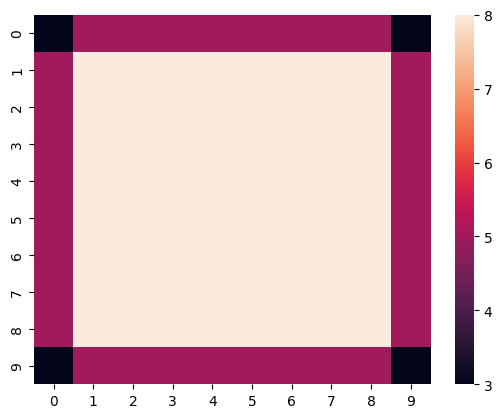

In [ ]:
ones = np.ones((10, 10))
results = get_neighbour_sum_matrix_conv(ones)
sns.heatmap(results)

# Time of the simulation

In [ ]:
import os
import random

simulations  = []
for root, dir, files in os.walk("Rust/Demo"):

    if 'parameters.csv' in files:
        reader = csv.DictReader(open( root + "/parameters.csv" ))
        par_dict = next(reader)
        temp = float(par_dict['Temperature']) 
        simulations.append((f"{root}/{random.choice(dir)}", temp))

n_cols = 2
n_rows = len(simulations)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (9, n_rows * 2))

plot_columns = ["Energy", "Diff Rolling"]
for ax, col in zip(axes[0], plot_columns):
    ax.set_title(col)

for index, (sim, temp) in enumerate(simulations):
    # Statistics
    columns = ['iter','energy','mag']
    df = pd.read_csv(f"{sim}/data.csv", header=None, names=columns).set_index('iter')

    # Energy plot
    axes[index][0].plot(df.energy)
    
    # Energy plot
    energy_diff = df.energy.diff().rolling(100).mean()
    axes[index][1].plot(energy_diff)
    oscilating_points = energy_diff[energy_diff.abs() < 2.5 * np.log(1+temp)]
    axes[index][1].scatter(oscilating_points.index, oscilating_points, color = 'g')


